# Capstone Project - The Battle of Neighborhoods

# Code

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


#### Get the neighborhoods data

In [2]:
# Load the data from JSON file
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

# All the relevant data is in the "features" key, which is basically a list of the neighborhoods. 
# So, let's define a new variable that includes this data.
neighborhoods_data = newyork_data['features']

#Tranform the data into a pandas dataframe called neighborhoods
column_names = ['Borough','Neighborhood','Latitude','Longitude']
neighborhoods = pd.DataFrame(columns=column_names)

# Loop for 306 times
for i in neighborhoods_data:
    borough = i['properties']['borough']
    neighborhood_name = i['properties']['name']
    neighborhood_lat = i['geometry']['coordinates'][1]
    neighborhood_lon = i['geometry']['coordinates'][0]
    
    neighborhoods = neighborhoods.append({'Borough':borough, 
                                          'Neighborhood': neighborhood_name, 
                                          'Latitude':neighborhood_lat,
                                          'Longitude':neighborhood_lon},ignore_index=True)
print(neighborhoods.shape)
neighborhoods.head(20)

(306, 4)


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585
5,Bronx,Kingsbridge,40.881687,-73.902818
6,Manhattan,Marble Hill,40.876551,-73.910660
7,Bronx,Woodlawn,40.898273,-73.867315
8,Bronx,Norwood,40.877224,-73.879391
9,Bronx,Williamsbridge,40.881039,-73.857446


In [3]:
neighborhoods['Borough'].unique()
print("There are",len(neighborhoods['Borough'].unique()), "Boroughs in Newyork")

neighborhoods.shape[0]
print("There are",neighborhoods.shape[0], "neighborhoods in Newyork")


There are 5 Boroughs in Newyork
There are 306 neighborhoods in Newyork


#### Get Geo-coordinates of Newyork

In [4]:
address = 'New York'
# lets convert the address into equivalent latitude and longitude values, 
# which is one of inputs to fetch the location data using foursquare API

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print (latitude, longitude)

40.7127281 -74.0060152


#### Create a map of New York with neighborhoods superimposed on top.

In [5]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude,longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

#### Data Visualization

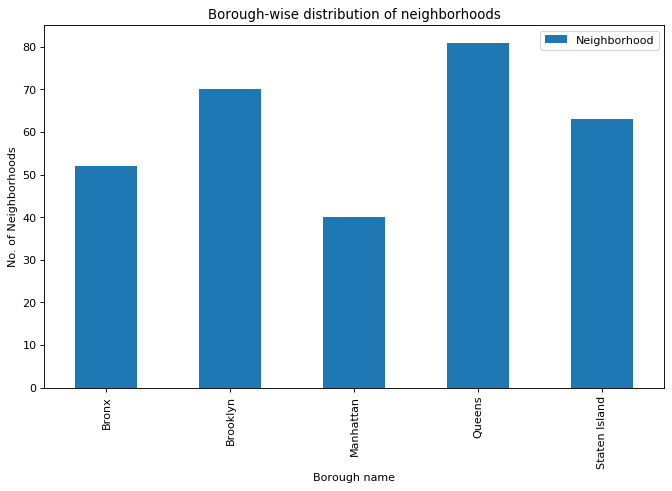

In [6]:
import matplotlib.pyplot as plt

df = neighborhoods.groupby('Borough').count()

plt.figure(figsize=(10,6), dpi=80)

df['Neighborhood'].plot(kind='bar')
plt.title("Borough-wise distribution of neighborhoods")
plt.xlabel("Borough name")
plt.ylabel("No. of Neighborhoods")
plt.legend()
plt.show()

From above figure, It is clear that Queens borough has highest no. of Neighborhoods 

Lets explore Queens borough to find out if there any any indian restaurants

Extract a separate data frame for Queens borough

In [7]:
queens_data = neighborhoods[neighborhoods['Borough'] == 'Queens'].reset_index(drop=True)
print(queens_data.shape)
queens_data.head()

(81, 4)


,Borough,Neighborhood,Latitude,Longitude
0,Queens,Astoria,40.768509,-73.915654
1,Queens,Woodside,40.746349,-73.901842
2,Queens,Jackson Heights,40.751981,-73.882821
3,Queens,Elmhurst,40.744049,-73.881656
4,Queens,Howard Beach,40.654225,-73.838138


Get Geo ordinates of Queens borough

In [8]:
address = 'Queens, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Queens are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Queens are 40.7498243, -73.7976337.


In [9]:
# create map of New York using latitude and longitude values
map_queens = folium.Map(location=[latitude,longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(queens_data['Latitude'], queens_data['Longitude'], queens_data['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_queens)  
    
map_queens


Explore Queens borough with the help of Foursquare API

In [10]:
CLIENT_ID = 'MNPFMEWTTTNEYZCUXJRYWJKI14EJRWTFQCJFQKVYBRQBSA5N' # your Foursquare ID
CLIENT_SECRET = 'IOMIYJHZUKV3AXO12SZ1XWLPBP1IMZM2B4C3JKNU1G3CD0MQ' # your Foursquare Secret
VERSION = '20180605'
LIMIT = 100
radius = 5000

#Construct Foursquare API
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        latitude,
        longitude,
        radius,
        LIMIT
        )

# Get top 100 venues within 1000 meters radius for a given latitude and longitude values 
results = requests.get(url).json()
results


{'meta': {'code': 200, 'requestId': '5efade9583d66d03120b44af'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'},
    {'name': '$-$$$$', 'key': 'price'}]},
  'headerLocation': 'Queens',
  'headerFullLocation': 'Queens',
  'headerLocationGranularity': 'city',
  'totalResults': 240,
  'suggestedBounds': {'ne': {'lat': 40.794824345000045,
    'lng': -73.73834386082912},
   'sw': {'lat': 40.704824254999956, 'lng': -73.8569235391709}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bd3afcd462cb713701fdf07',
       'name': 'Pizza Garden',
       'location': {'address': '171-01 Northern Blvd',
        'crossStreet': '171st Street',
        'lat': 40.75819304664331,
        'lng': -73.79571933753546,
        'l

In [11]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [12]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

print(nearby_venues.shape)
nearby_venues.head(50)
                   

(100, 4)


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Pizza Garden,Pizza Place,40.758193,-73.795719
1,Kissena Park,Park,40.747715,-73.808877
2,Bagel Oasis,Bagel Shop,40.739460,-73.790554
3,AMC Fresh Meadows 7,Movie Theater,40.741098,-73.784097
4,Arirang,Korean Restaurant,40.761282,-73.802799
5,Mad For Chicken,Korean Restaurant,40.763426,-73.807724
6,Queens Archery Lanes & Pro Shop,Athletics & Sports,40.761575,-73.795557
7,Ganesh Temple Canteen,Indian Restaurant,40.752465,-73.816384
8,BKNY Thai Restaurant,Thai Restaurant,40.753085,-73.779995
9,iLoveKickboxing,Boxing Gym,40.768096,-73.790563


In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=5000):
    
    venues_list=[]
    LIMIT=100
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Get the list of all neighborhooods in Queen borough

In [16]:
queens_venues = getNearbyVenues(names=queens_data['Neighborhood'],
                                   latitudes=queens_data['Latitude'],
                                   longitudes=queens_data['Longitude']
                                  )

Astoria
Woodside
Jackson Heights
Elmhurst
Howard Beach
Corona
Forest Hills
Kew Gardens
Richmond Hill
Flushing
Long Island City
Sunnyside
East Elmhurst
Maspeth
Ridgewood
Glendale
Rego Park
Woodhaven
Ozone Park
South Ozone Park
College Point
Whitestone
Bayside
Auburndale
Little Neck
Douglaston
Glen Oaks
Bellerose
Kew Gardens Hills
Fresh Meadows
Briarwood
Jamaica Center
Oakland Gardens
Queens Village
Hollis
South Jamaica
St. Albans
Rochdale
Springfield Gardens
Cambria Heights
Rosedale
Far Rockaway
Broad Channel
Breezy Point
Steinway
Beechhurst
Bay Terrace
Edgemere
Arverne
Rockaway Beach
Neponsit
Murray Hill
Floral Park
Holliswood
Jamaica Estates
Queensboro Hill
Hillcrest
Ravenswood
Lindenwood
Laurelton
Lefrak City
Belle Harbor
Rockaway Park
Somerville
Brookville
Bellaire
North Corona
Forest Hills Gardens
Jamaica Hills
Utopia
Pomonok
Astoria Heights
Hunters Point
Sunnyside Gardens
Blissville
Roxbury
Middle Village
Malba
Hammels
Bayswater
Queensbridge


In [17]:
queens_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Astoria,40.768509,-73.915654,Titan Foods Inc.,40.769198,-73.919253,Gourmet Shop
1,Astoria,40.768509,-73.915654,Ample Hills Creamery,40.765562,-73.919012,Ice Cream Shop
2,Astoria,40.768509,-73.915654,Al-sham Sweets and Pastries,40.768077,-73.911561,Middle Eastern Restaurant
3,Astoria,40.768509,-73.915654,CrossFit Queens,40.769404,-73.918977,Gym
4,Astoria,40.768509,-73.915654,Brooklyn Bagel & Coffee Co.,40.764732,-73.916944,Bagel Shop


In [18]:
queens_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Arverne,85,85,85,85,85,85
Astoria,100,100,100,100,100,100
Astoria Heights,100,100,100,100,100,100
Auburndale,100,100,100,100,100,100
Bay Terrace,100,100,100,100,100,100
Bayside,100,100,100,100,100,100
Bayswater,100,100,100,100,100,100
Beechhurst,100,100,100,100,100,100
Bellaire,100,100,100,100,100,100


In [19]:
print('There are {} uniques categories.'.format(len(queens_venues['Venue Category'].unique())))

There are 264 uniques categories.


In [20]:
# one hot encoding
queens_onehot = pd.get_dummies(queens_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
queens_onehot['Neighborhood'] = queens_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [queens_onehot.columns[-1]] + list(queens_onehot.columns[:-1])
queens_onehot = queens_onehot[fixed_columns]

queens_onehot.head()

,Zoo,Accessories Store,Airport Food Court,Airport Lounge,Airport Service,American Restaurant,Aquarium,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bistro,Board Shop,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Basketball Court,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dosa Place,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Gas Station,Gastropub,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,Hobby Shop,Hookah Bar,Hot Dog Joint,Hotel,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern Greek Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Museum,Music Venue,Nail Salon,National Park,Neighborhood,New American Restaurant,Nightclub,Noodle House,Optical Shop,Other Great Outdoors,Other Nightlife,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Pub,Public Art,Racetrack,Record Shop,Rental Car Location,Reservoir,Residential Building (Apartment / Condo),Resort,Restaurant,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,South American Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stables,State / Provincial Park,Steakhouse,Street Art,Street Food Gathering,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tech Startup,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Tibetan Restaurant,Toll Plaza,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Waterfront,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [21]:
queens_onehot.shape

(8019, 264)

In [22]:
queens_grouped = queens_onehot.groupby('Neighborhood').mean().reset_index()
print(queens_grouped.shape)
queens_grouped.head(10)

(81, 264)


,Neighborhood,Zoo,Accessories Store,Airport Food Court,Airport Lounge,Airport Service,American Restaurant,Aquarium,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bistro,Board Shop,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Basketball Court,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dosa Place,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Gas Station,Gastropub,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,Hobby Shop,Hookah Bar,Hot Dog Joint,Hotel,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern Greek Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Museum,Music Venue,Nail Salon,National Park,New American Restaurant,Nightclub,Noodle House,Optical Shop,Other Great Outdoors,Other Nightlife,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Pub,Public Art,Racetrack,Record Shop,Rental Car Location,Reservoir,Residential Building (Apartment / Condo),Resort,Restaurant,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,South American Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stables,State / Provincial Park,Steakhouse,Street Art,Street Food Gathering,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tech Startup,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Tibetan Restaurant,Toll Plaza,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Waterfront,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Arverne,0.0,0.0,0.00,0.00,0.00,0.011765,0.0,0.011765,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.000000,0.058824,0.023529,0.0,0.011765,0.000000,0.

Data Visualization - Neighborhood-wise mean distribution of Indian restaurants

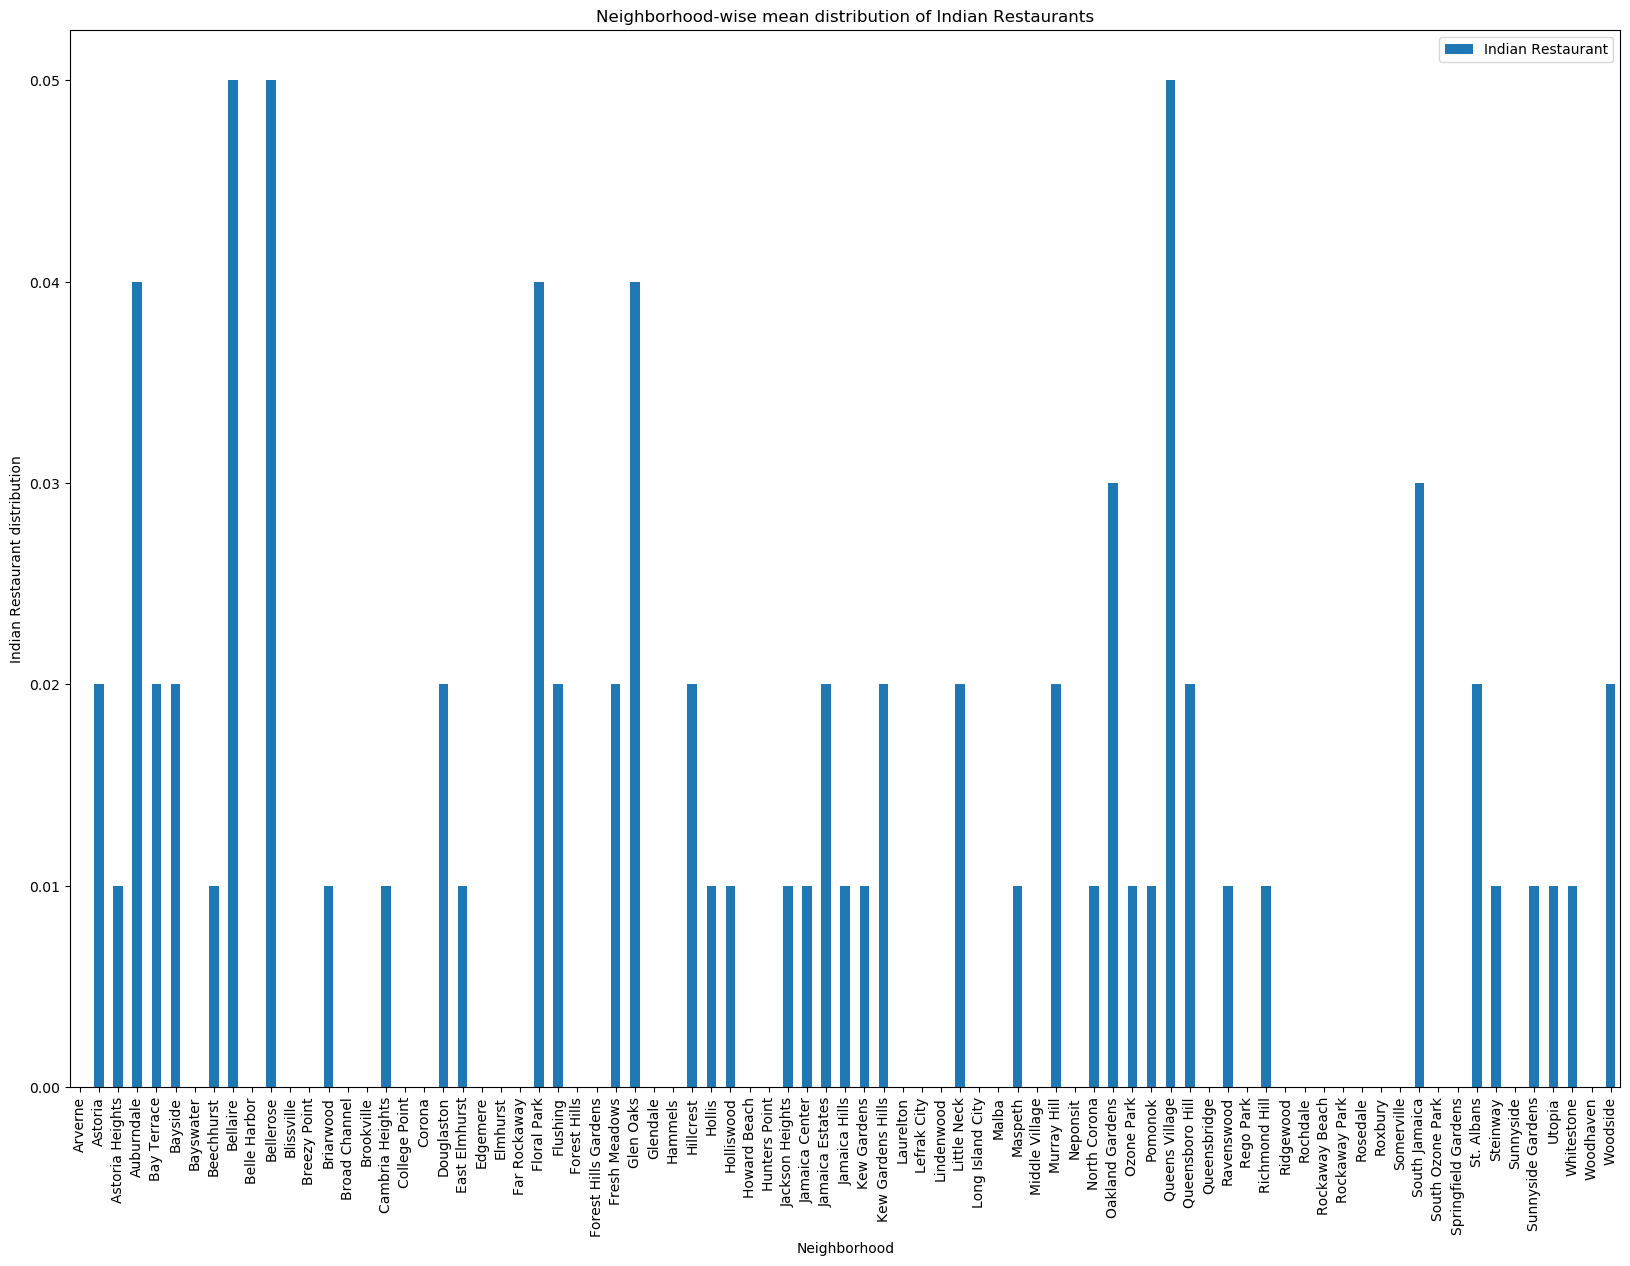

In [23]:
import matplotlib.pyplot as plt
df = queens_grouped.groupby('Neighborhood')['Indian Restaurant'].mean()
#df.sort_values('Indian Restaurant',ascending=False,inplace=True,na_position='last')
#df=df.sort_values('Indian Restaurant',ascending=False)
plt.figure(figsize=(20,14), dpi=100)

df.plot(kind='bar')
plt.title("Neighborhood-wise mean distribution of Indian Restaurants")
plt.xlabel("Neighborhood")
plt.ylabel("Indian Restaurant distribution")
plt.legend()
plt.show()

Insight:The neighborhoods Bellaire, Bellerose and Queen Village has high number of Indian restaurants with mean of 0.05. These are followed by Auburndale, Flora park and Glen oaks with mean of 0.04

Let's print each neighborhood along with the top 20 most common venues

In [24]:
num_top_venues = 20

for hood in queens_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = queens_grouped[queens_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Arverne----
                         venue  freq
0                        Beach  0.36
1                   Bagel Shop  0.06
2                  Pizza Place  0.06
3                    Surf Spot  0.05
4                  Coffee Shop  0.02
5                    Beach Bar  0.02
6           Italian Restaurant  0.02
7                       Bakery  0.02
8                      Brewery  0.01
9                National Park  0.01
10                Burger Joint  0.01
11                  Taco Place  0.01
12        Caribbean Restaurant  0.01
13          Chinese Restaurant  0.01
14                  Steakhouse  0.01
15        Gym / Fitness Center  0.01
16                 Golf Course  0.01
17                  Board Shop  0.01
18         Sporting Goods Shop  0.01
19  Construction & Landscaping  0.01


----Astoria----
                        venue  freq
0                 Pizza Place  0.07
1                         Bar  0.05
2            Greek Restaurant  0.04
3          Italian Restaurant  0.04
4        

In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [26]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = queens_grouped['Neighborhood']

for ind in np.arange(queens_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(queens_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arverne,Beach,Pizza Place,Bagel Shop,Surf Spot,Bakery,Italian Restaurant,Coffee Shop,Beach Bar,Breakfast Spot,Event Space
1,Astoria,Pizza Place,Bar,Italian Restaurant,Greek Restaurant,Thai Restaurant,Park,Bagel Shop,Bakery,Ice Cream Shop,Butcher
2,Astoria Heights,Greek Restaurant,Bagel Shop,Bar,Pizza Place,Italian Restaurant,Bakery,Coffee Shop,Thai Restaurant,Cheese Shop,South American Restaurant
3,Auburndale,Pizza Place,Korean Restaurant,Bakery,Greek Restaurant,Park,Indian Restaurant,Bagel Shop,Cosmetics Shop,Hotpot Restaurant,Supermarket
4,Bay Terrace,Greek Restaurant,Bakery,Deli / Bodega,Pizza Place,Park,Bagel Shop,Italian Restaurant,Cosmetics Shop,Ice Cream Shop,Korean Restaurant


Clustering of neighborhoods of Queens borough

In [27]:
# set the number of clusters
kclusters = 3

queens_grouped_clustering = queens_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(queens_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 2, 2, 2, 2, 2, 1, 2, 2, 1], dtype=int32)

In [28]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

queens_merged = queens_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
queens_merged = queens_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

queens_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Queens,Astoria,40.768509,-73.915654,2,Pizza Place,Bar,Italian Restaurant,Greek Restaurant,Thai Restaurant,Park,Bagel Shop,Bakery,Ice Cream Shop,Butcher
1,Queens,Woodside,40.746349,-73.901842,2,Pizza Place,Thai Restaurant,Bakery,Bagel Shop,Mexican Restaurant,Italian Restaurant,Greek Restaurant,Sushi Restaurant,South American Restaurant,Pub
2,Queens,Jackson Heights,40.751981,-73.882821,2,Pizza Place,Thai Restaurant,Bakery,Bagel Shop,Park,South American Restaurant,Yoga Studio,Empanada Restaurant,Brewery,Butcher
3,Queens,Elmhurst,40.744049,-73.881656,2,Pizza Place,Thai Restaurant,Bakery,Sushi Restaurant,Bagel Shop,South American Restaurant,Mexican Restaurant,Park,Italian Restaurant,Tennis Stadium
4,Queens,Howard Beach,40.654225,-73.838138,0,Pizza Place,Pharmacy,Caribbean Restaurant,Discount Store,Ice Cream Shop,Bakery,Italian Restaurant,Burger Joint,Pet Store,Restaurant


In [29]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(queens_merged['Latitude'], queens_merged['Longitude'], queens_merged['Neighborhood'], queens_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Examine the Clusters

In [30]:
queens_merged.loc[queens_merged['Cluster Labels'] == 0]

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Queens,Howard Beach,40.654225,-73.838138,0,Pizza Place,Pharmacy,Caribbean Restaurant,Discount Store,Ice Cream Shop,Bakery,Italian Restaurant,Burger Joint,Pet Store,Restaurant
7,Queens,Kew Gardens,40.705179,-73.829819,0,Pizza Place,Caribbean Restaurant,Bakery,Burger Joint,Boxing Gym,Bagel Shop,Plaza,Sushi Restaurant,Bar,Peruvian Restaurant
8,Queens,Richmond Hill,40.697947,-73.831833,0,Pizza Place,Caribbean Restaurant,Bakery,Burger Joint,Bar,Bagel Shop,Plaza,Movie Theater,Food Truck,Boxing Gym
18,Queens,Ozone Park,40.680708,-73.843203,0,Pizza Place,Caribbean Restaurant,Italian Restaurant,Pet Store,Ice Cream Shop,Deli / Bodega,Latin American Restaurant,Restaurant,Coffee Shop,Baseball Field
19,Queens,South Ozone Park,40.668550,-73.809865,0,Pizza Place,Caribbean Restaurant,Airport Lounge,Restaurant,Gym,Sushi Restaurant,Southern / Soul Food Restaurant,Italian Restaurant,Mexican Restaurant,Coffee Shop
30,Queens,Briarwood,40.710935,-73.811748,0,Pizza Place,Caribbean Restaurant,Bakery,Bar,Seafood Restaurant,Coffee Shop,Sushi Restaurant,Ice Cream Shop,Vegetarian / Vegan Restaurant,Bagel Shop
31,Queens,Jamaica Center,40.704657,-73.796902,0,Pizza Place,Caribbean Restaurant,Bakery,Bagel Shop,Ice Cream Shop,Park,Coffee Shop,Thai Restaurant,Grocery Store,Movie Theater
34,Queens,Hollis,40.711243,-73.759250,0,Pizza Place,Caribbean Restaurant,Park,Deli / Bodega,Gym,Sandwich Place,Vegetarian / Vegan Restaurant,Coffee Shop,Trail,Sushi Restaurant
35,Queens,South Jamaica,40.696911,-73.790426,0,Caribbean Restaurant,Pizza Place,Park,Vegetarian / Vegan Restaurant,Bakery,Southern / Soul Food Restaurant,Indian Restaurant,Coffee Shop,Gym,BBQ Joint
36,Queens,St. Albans,40.694445,-73.758676,0,Caribbean Restaurant,Pizza Place,Park,Deli / Bodega,Bakery,Italian Restaurant,Vegetarian / Vegan Restaurant,Sandwich Place,Pharmacy,Gym


In [31]:
queens_merged.loc[queens_merged['Cluster Labels'] == 1]

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
41,Queens,Far Rockaway,40.603134,-73.754980,1,Beach,Golf Course,Bagel Shop,Coffee Shop,Italian Restaurant,Pizza Place,Sandwich Place,Surf Spot,Chinese Restaurant,Ice Cream Shop
42,Queens,Broad Channel,40.603027,-73.820055,1,Beach,Bagel Shop,Surf Spot,Pizza Place,Donut Shop,Coffee Shop,Boutique,Ice Cream Shop,Beach Bar,Bakery
47,Queens,Edgemere,40.595642,-73.776133,1,Beach,Pizza Place,Bagel Shop,Surf Spot,Ice Cream Shop,Chinese Restaurant,Coffee Shop,Donut Shop,Sandwich Place,Beach Bar
48,Queens,Arverne,40.589144,-73.791992,1,Beach,Pizza Place,Bagel Shop,Surf Spot,Bakery,Italian Restaurant,Coffee Shop,Beach Bar,Breakfast Spot,Event Space
49,Queens,Rockaway Beach,40.582802,-73.822361,1,Beach,Pizza Place,Bagel Shop,Surf Spot,Ice Cream Shop,Donut Shop,Bakery,Coffee Shop,Beach Bar,Pub
50,Queens,Neponsit,40.572037,-73.857547,1,Beach,Bagel Shop,Pizza Place,Donut Shop,Bar,Ice Cream Shop,National Park,Pharmacy,Bakery,Park
61,Queens,Belle Harbor,40.576156,-73.854018,1,Beach,Bagel Shop,Pizza Place,Donut Shop,Seafood Restaurant,Pharmacy,Bakery,Beach Bar,National Park,Park
62,Queens,Rockaway Park,40.580343,-73.841534,1,Beach,Bagel Shop,Pizza Place,Surf Spot,National Park,Park,Beach Bar,Seafood Restaurant,Bakery,Ice Cream Shop
63,Queens,Somerville,40.597711,-73.796648,1,Beach,Pizza Place,Donut Shop,Surf Spot,Bagel Shop,Ice Cream Shop,Sandwich Place,Coffee Shop,Bakery,Chinese Restaurant
75,Queens,Roxbury,40.567376,-73.892138,1,Beach,Donut Shop,Seafood Restaurant,Bagel Shop,Bank,Ice Cream Shop,Restaurant,Park,Turkish Restaurant,Pharmacy


In [32]:
queens_merged.loc[queens_merged['Cluster Labels'] == 2]

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Queens,Astoria,40.768509,-73.915654,2,Pizza Place,Bar,Italian Restaurant,Greek Restaurant,Thai Restaurant,Park,Bagel Shop,Bakery,Ice Cream Shop,Butcher
1,Queens,Woodside,40.746349,-73.901842,2,Pizza Place,Thai Restaurant,Bakery,Bagel Shop,Mexican Restaurant,Italian Restaurant,Greek Restaurant,Sushi Restaurant,South American Restaurant,Pub
2,Queens,Jackson Heights,40.751981,-73.882821,2,Pizza Place,Thai Restaurant,Bakery,Bagel Shop,Park,South American Restaurant,Yoga Studio,Empanada Restaurant,Brewery,Butcher
3,Queens,Elmhurst,40.744049,-73.881656,2,Pizza Place,Thai Restaurant,Bakery,Sushi Restaurant,Bagel Shop,South American Restaurant,Mexican Restaurant,Park,Italian Restaurant,Tennis Stadium
5,Queens,Corona,40.742382,-73.856825,2,Tennis Stadium,Thai Restaurant,Pizza Place,Italian Restaurant,Burger Joint,Chinese Restaurant,Peruvian Restaurant,Mexican Restaurant,South American Restaurant,Boxing Gym
6,Queens,Forest Hills,40.725264,-73.844475,2,Tennis Stadium,Pizza Place,Bakery,Burger Joint,Park,Italian Restaurant,Ice Cream Shop,Mediterranean Restaurant,Deli / Bodega,Bar
9,Queens,Flushing,40.764454,-73.831773,2,Chinese Restaurant,Korean Restaurant,Tennis Stadium,Park,Pizza Place,Bakery,Deli / Bodega,Gym / Fitness Center,Hotpot Restaurant,Dumpling Restaurant
10,Queens,Long Island City,40.750217,-73.939202,2,Park,Bakery,Cocktail Bar,Sandwich Place,Art Museum,Bar,Gym,Plaza,Butcher,Pizza Place
11,Queens,Sunnyside,40.740176,-73.926916,2,Cocktail Bar,Park,Bakery,Pizza Place,Italian Restaurant,Bar,Ice Cream Shop,Martial Arts Dojo,Brewery,Butcher
12,Queens,East Elmhurst,40.764073,-73.867041,2,Tennis Stadium,Thai Restaurant,Pizza Place,Deli / Bodega,Italian Restaurant,Chinese Restaurant,Bakery,Mexican Restaurant,Greek Restaurant,South American Restaurant


#### Summary:
- The neighborhoods Bellaire, Bellerose and Queen Village has high number of Indian restaurants with mean of 0.05. 
- These are followed by Auburndale, Flora park and Glen oaks with mean of 0.04

- Cluster-3 has relatively more number of indian restaurants as common venues, compared to other clusters. we can recommend this cluster of neighborhoods to people to explore indian restaurants.
- Cluster-2 has no Indian restaurants as any of top-10 common places across all neighborhoods. Hence it is not cluster of our interest.
- Cluster-1 has very few Indian cuisine based restaurants and one can explore it if cluster-3 based restaurants are already experienced.
